## CV Job Matching using Doc2Vec

### Introduction
CV Job Matching using Doc2Vec is a technique that aims to match job descriptions with resumes by representing them as numerical vectors using the Doc2Vec model. This approach allows for efficient comparison and similarity calculation between textual documents.

In the field of machine learning, representing text documents numerically is a challenging task. However, it is essential for various applications, such as document retrieval, web search, spam filtering, and topic modeling. Doc2Vec, a variation of the Word2Vec algorithm, provides a solution by generating vector representations from words.

**Word2Vec** algorithms, such as **Continuous Bag-of-Words (CBOW)** and **Skip-Gram**, are used to create Word2Vec representations. CBOW predicts the current word based on the surrounding words in a sliding window context. Each word is then converted into a feature vector, and these vectors become the word vectors after training. On the other hand, Skip-Gram predicts the surrounding words given the current word. It is slower than CBOW but is known for its accuracy with infrequent words.

### Implementation

To implement CV Job Matching using Doc2Vec, we start by importing the necessary libraries and loading the job data from a CSV file. We preprocess the data, keeping only the relevant columns, and merge them into a new column called 'data.' Then, we tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

Next, we initialize the Doc2Vec model with specific parameters, such as the vector size, minimum count, and number of epochs. We build the vocabulary by feeding the tagged data to the model, and then train the model on the tagged data.

After training, we save the model for future use. To match a resume with a job description, we load the saved model and preprocess the resume and job description text. We convert them to lowercase, remove punctuation and numerical values.

Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description. The cosine similarity score ranges from -1 to 1, with 1 indicating a perfect match and -1 indicating no similarity.

By employing Doc2Vec and cosine similarity, this approach enables efficient and effective matching between job descriptions and resumes, helping to streamline the job application process and enhance the chances of finding the right candidates for specific positions.

Finally, the author also employs Gauge chart from Plotly to show the matching percentage with threshold that users could consider modifying thier CV to pass Application Tracking System (TSA) from the majority of employers.

### Coding
#### 1. Set up

In [ ]:
# Install all dependencies

!pip install pandas scikit-learn gensim nltk numpy requests PyPDF2 pinecone-client transformers torch spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 21.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [ ]:
# Import libraries
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from numpy.linalg import norm
from termcolor import colored
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import requests
import PyPDF2
import re
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import string
import pinecone
import spacy
from transformers import pipeline
from collections import defaultdict
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### 2. Prepare data
This dataset that we trained our model contains current job postings available on the City of New York’s official jobs site in 2020. You can follow this link to download:
[New York Job Posting Dataset](https://data.world/city-of-ny/kpav-sd4t)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
df = pd.read_csv('drive/MyDrive/dice_com-job_us_sample.csv')
# Check data
df.head()

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,https://www.dice.com/jobs/detail/AUTOMATION-TE...,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Dice Id : 10110693,"Atlanta, GA",AUTOMATION TEST ENGINEER,1 hour ago,Telecommuting not available|Travel not required,NaN,SEE BELOW,418ff92580b270ef4e7c14f0ddfc36b4
1,https://www.dice.com/jobs/detail/Information-S...,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Dice Id : 10114469,"Chicago, IL",Information Security Engineer,1 week ago,Telecommuting not available|Travel not required,NaN,"linux/unix, network monitoring, incident respo...",8aec88cba08d53da65ab99cf20f6f9d9
2,https://www.dice.com/jobs/detail/Business-Solu...,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Dice Id : CXGALXYS,"Schaumburg, IL",Business Solutions Architect,2 weeks ago,Telecommuting not available|Travel not required,NaN,"Enterprise Solutions Architecture, business in...",46baa1f69ac07779274bcd90b85d9a72
3,https://www.dice.com/jobs/detail/Java-Develope...,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Dice Id : 10113627,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",2 weeks ago,Telecommuting not available|Travel not required,NaN,Please see job description,3941b2f206ae0f900c4fba4ac0b18719
4,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7


Since head() fuction does not show all data, we check column names to retain only necessary variables.

In [ ]:
# Show column name
df.columns

Index(['advertiserurl', 'company', 'employmenttype_jobstatus',
       'jobdescription', 'jobid', 'joblocation_address', 'jobtitle',
       'postdate', 'shift', 'site_name', 'skills', 'uniq_id'],
      dtype='object')

Keep only some columns to train the model

In [ ]:
# Select relevant columns
relevant_columns = ['jobtitle','jobdescription', 'skills']
df = df[relevant_columns]

df

,jobtitle,jobdescription,skills
0,AUTOMATION TEST ENGINEER,Looking for Selenium engineers...must have sol...,SEE BELOW
1,Information Security Engineer,The University of Chicago has a rapidly growin...,"linux/unix, network monitoring, incident respo..."
2,Business Solutions Architect,"GalaxE.SolutionsEvery day, our solutions affec...","Enterprise Solutions Architecture, business in..."
3,"Java Developer (mid level)- FT- GREAT culture,...",Java DeveloperFull-time/direct-hireBolingbrook...,Please see job description
4,DevOps Engineer,Midtown based high tech firm has an immediate ...,"Configuration Management, Developer, Linux, Ma..."
...,...,...,...
21995,Web Designer,Company Description We are searching for a ta...,"UI/UX mobile apps, interaction design, digital..."
21996,Senior Front End Web Developer - Full Time at ...,CONTACT - priya@omegasolutioninc.com / 408-45...,"JavaScript, HTML5, CSS3, Bootstrap, AJAX, Reac..."
21997,QA Analyst,Do you take pride in your work knowing that th...,"SDLC, ALM, SQL, T-SQL, RedGate, Team Foundatio..."
21998,Tech Lead-Full Stack,Company Description What We Can Offer YouAs th...,"Python, Ruby, Go, Clojure, Java, NoSQL-Databas..."


In [ ]:
def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)
    return text

In [ ]:
# Create a new column called 'data' and merge the values of the other columns into it
df['data'] = df[relevant_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# Drop the individual columns if you no longer need them
df.drop(relevant_columns, axis=1, inplace=True)
# Preview the updated dataframe
print(df.head())

                                                data
0  AUTOMATION TEST ENGINEER Looking for Selenium ...
1  Information Security Engineer The University o...
2  Business Solutions Architect GalaxE.SolutionsE...
3  Java Developer (mid level)- FT- GREAT culture,...
4  DevOps Engineer Midtown based high tech firm h...


#### 3. Tokenize data
We tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

In [ ]:
# Tag data
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(preprocess_text(_d)), tags = [str(i)]) for i, _d in enumerate(data)]

#### 4. Model initialization and vocabulary buiding
Next, we initialize the Doc2Vec model with specific parameters.

**Parameters** of Doc2Vec are as follows:

- `vector_size`: Dimensionality of the feature vectors. Default: 100.
- `window`: The window refers to the maximum distance between the target word and its context words within a sentence. Default: 5.
- `min_count`: Ignores all words with a total frequency lower than this. Default: 5.
- `epochs`: Number of iterations (epochs) over the corpus. Defaults to 5 for PV-DBOW and 10 for PV-DM.
- `dm`: Defines the training algorithm. If `dm = 1`, the Distributed Memory (PV-DM) model is used. If `dm = 0`, the Distributed Bag of Words (PV-DBOW) model is used. Default: 1 (PV-DM).
- `dbow_words`: If set to 1, trains word vectors (in addition to document vectors) using the PV-DBOW algorithm. Default: 0 (False).
- `dm_mean`: If set to 1, uses the mean of the context word vectors instead of concatenation when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_concat`: If set to 1, concatenates the document and context word vectors when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_tag_count`: Expected number of document tags per document, when using the PV-DM algorithm. Default: 1.
- `dbow_tag_count`: Expected number of document tags per document, when using the PV-DBOW algorithm. Default: 1.
- `alpha`: The initial learning rate. Default: 0.025.
- `min_alpha`: The learning rate will linearly drop to `min_alpha` as training progresses. Default: 0.0001.
- `hs`: If set to 1, hierarchical softmax activation function will be used. Default: 0 (Negative Sampling).
- `negative`: If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn. Default: 5.
- `ns_exponent`: The exponent used to shape the negative sampling distribution. Default: 0.75.


In [ ]:
#Model initialization
model = Doc2Vec(vector_size = 10,
window = 5,
min_count = 5,
epochs = 50,
workers = 4
)

#model = Doc2Vec(vector_size=100, min_count=2, epochs=100, dm=1)

In [ ]:
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

19403


#### 5. Train and save the model
Train the model on tagged data.

In [ ]:
import time

# Train the model
# for epoch in range(model.epochs):
#     print(f"Training epoch {epoch+1}/{model.epochs}")
#     start_time = time.time()
#     model.train(tagged_data,
#                 total_examples=model.corpus_count,
#                 epochs=model.epochs)
#     end_time = time.time()
#     print("Tiempo de demora ", end_time - start_time)
# model.save('cv_job_maching.model')
# print("Model saved")
start_time = time.time()
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
end_time = time.time()
print("Tiempo de demora ", (end_time - start_time)/60)
model.save('cv_job_maching_vector_size_10_window_5_min_count_5_epochs_50_brandon.model')

Tiempo de demora  8.583076071739196


#### 6. Inputs of CV and JD

- **Resume**:

In this case, I assume that we upload our CV in PDF file, so I use PyPDF2 to extract data. You can also change how to read inputs appropreately.

In [ ]:
# Extract text from PDF
def extract_text_from_pdf(pdf_path):
    pdf = PyPDF2.PdfReader(pdf_path)
    resume_text = ""
    for page in pdf.pages:
        resume_text += page.extract_text()
    return resume_text

# pdf_path = '/content/Akshay_Srimatrix.pdf'
# resume_text = extract_text_from_pdf(pdf_path)

- **Job Description**:

From my perspective, I believe candidates will copy and paste the JD into textbox to check the matching percentage, so I will have JD Input in text as below.

In [ ]:
def preprocess_CV_JD(text):
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation from the text
    text = re.sub('[^a-z0-9]', ' ', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Tokenize the text
    words = word_tokenize(text)

    # POS tagging:etiquetado gramatical
    # es el proceso de marcar una palabra en un texto como correspondiente a una parte
    # particular del discurso, en función tanto de su definición como de su contexto.
    pos_tags = pos_tag(words)

    # Filter words: keep nouns (NN, NNP, NNPS, NNS), adjectives (JJ, JJR, JJS), and numbers (CD)
    allowed_tags = {'NN', 'NNP', 'NNPS', 'NNS', 'JJ', 'JJR', 'JJS', 'CD'}
    filtered_words = [word for word, tag in pos_tags if tag in allowed_tags]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in filtered_words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tag(filtered_words)]

    text = ' '.join(lemmatized_words)
    return text

def get_wordnet_pos(treebank_tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match

# Example usage
text = """
Position: Front End Developer

Description:
Creative Tech Solutions is seeking a talented Front End Developer to join our dynamic team. The ideal candidate will have a strong background in web development and a passion for creating visually appealing and user-friendly web interfaces. You will work closely with our design and development teams to build responsive, high-performance websites and applications.

Responsibilities:

    Develop and maintain web applications using HTML, CSS, and JavaScript.
    Collaborate with UX/UI designers to translate design mockups into interactive features.
    Optimize web applications for maximum speed and scalability.
    Implement responsive designs to ensure seamless user experience across all devices.
    Debug and resolve front-end issues and improve application performance.
    Stay up-to-date with the latest industry trends and best practices in front-end development.

Requirements:

    Bachelor's degree in Computer Science, Web Development, or a related field.
    Minimum of 3 years of experience in front-end development.
    Proficiency in HTML, CSS, and JavaScript.
    Experience with modern front-end frameworks such as React or Angular.
    Strong understanding of responsive design principles and cross-browser compatibility.
    Familiarity with version control systems like Git.
    Excellent problem-solving skills and attention to detail.
    Ability to work both independently and as part of a team.

Preferred Qualifications:

    Experience with Redux or similar state management libraries.
    Knowledge of TypeScript.
    Understanding of UX/UI design principles.
    Familiarity with RESTful APIs and asynchronous request handling.
    Experience with testing frameworks such as Jest or Mocha.
"""

processed_text = preprocess_CV_JD(text)
print(processed_text)

position front end developer description creative tech solution talented front end developer dynamic team ideal candidate strong background web development passion friendly web interface design development team responsive high performance website application responsibility web application html css javascript collaborate ux ui designer design mockups interactive feature web application maximum speed scalability implement responsive design seamless user experience device debug front end issue application performance date late industry trend best practice front end development requirement degree computer science web development related field minimum 3 year experience front end development proficiency html cs javascript experience modern front end framework react angular strong understanding responsive design principle cross browser compatibility familiarity version control system git excellent problem skill attention ability part team prefer qualification experience redux similar state ma

- **Develop a function to pre-process input text**:

**Pruebas mias**

In [ ]:
# Con esta job description y este cv la similaridad da del % 94.29 lo cual esta perfecto debido a que son completamente compatibles

data_jd = """
Position: Senior Data Scientist
Location: Remote
Company: Tech Innovators Inc.

Description:
Tech Innovators Inc. is seeking a Senior Data Scientist with experience in data analysis and predictive modeling. The ideal candidate should possess advanced skills in Python, SQL, and data visualization tools such as Tableau or Power BI. Experience in machine learning and natural language processing (NLP) is highly valued. The role involves close collaboration with product and engineering teams to develop data-driven solutions.

Requirements:

    Degree in Computer Science, Statistics, Mathematics, or related fields.
    Minimum of 5 years of experience in Data Science roles.
    Proven experience with Python, SQL, and data visualization.
    Knowledge of machine learning techniques and NLP.
    Strong analytical skills and the ability to solve complex problems."""

data_resume = """
Name: John Doe

Professional Profile:
Senior Data Scientist with over 5 years of experience in data analysis, predictive modeling, and machine learning. Expert in Python, SQL, and data visualization using tools such as Tableau and Power BI. Possess strong knowledge of NLP techniques and a proven ability to solve complex problems and generate actionable insights.

Work Experience:

    Senior Data Scientist | Tech Innovators Inc. | 2019 - Present
        Developed predictive models and analyzed large datasets.
        Implemented machine learning and NLP solutions.

    Data Analyst | Data Insights Ltd. | 2016 - 2019
        Conducted data analysis and generated reports for strategic decision-making.
        Created data visualizations and developed interactive dashboards.

Education:

    Master’s in Data Science | University of Barcelona | 2016
    Bachelor’s in Statistics | Complutense University of Madrid | 2014
    """




In [ ]:
front_jd = """
Position: Front End Developer

Description:
Creative Tech Solutions is seeking a talented Front End Developer to join our dynamic team. The ideal candidate will have a strong background in web development and a passion for creating visually appealing and user-friendly web interfaces. You will work closely with our design and development teams to build responsive, high-performance websites and applications.

Responsibilities:

    Develop and maintain web applications using HTML, CSS, and JavaScript.
    Collaborate with UX/UI designers to translate design mockups into interactive features.
    Optimize web applications for maximum speed and scalability.
    Implement responsive designs to ensure seamless user experience across all devices.
    Debug and resolve front-end issues and improve application performance.
    Stay up-to-date with the latest industry trends and best practices in front-end development.

Requirements:

    Bachelor's degree in Computer Science, Web Development, or a related field.
    Minimum of 3 years of experience in front-end development.
    Proficiency in HTML, CSS, and JavaScript.
    Experience with modern front-end frameworks such as React or Angular.
    Strong understanding of responsive design principles and cross-browser compatibility.
    Familiarity with version control systems like Git.
    Excellent problem-solving skills and attention to detail.
    Ability to work both independently and as part of a team.

Preferred Qualifications:

    Experience with Redux or similar state management libraries.
    Knowledge of TypeScript.
    Understanding of UX/UI design principles.
    Familiarity with RESTful APIs and asynchronous request handling.
    Experience with testing frameworks such as Jest or Mocha.
"""

front_resume = """
Professional Profile:
Front End Developer with over 4 years of experience in designing and developing responsive websites and web applications. Proficient in HTML, CSS, JavaScript, and frameworks like React and Angular. Strong understanding of UX/UI principles and a keen eye for design. Excellent problem-solving skills and a passion for creating seamless user experiences.

Work Experience:

    Front End Developer | Creative Web Solutions | 2020 - Present
        Designed and implemented responsive web interfaces using HTML, CSS, and JavaScript.
        Developed single-page applications (SPAs) using React and Redux.
        Collaborated with UX/UI designers to create user-friendly web experiences.

    Junior Front End Developer | Digital Innovations Ltd. | 2018 - 2020
        Assisted in the development of dynamic websites and applications using Angular.
        Participated in code reviews and team meetings to improve development processes.
        Maintained and updated existing web applications to enhance performance and usability.

Education:

    Bachelor’s in Computer Science | University of California, Berkeley | 2018

Skills:

    Proficient in HTML, CSS, JavaScript
    Experienced with React, Angular, Redux
    Knowledge of UX/UI principles
    Familiar with version control systems (Git)
    Strong debugging and troubleshooting skills

Projects:

    Portfolio Website: Developed a personal portfolio website using React to showcase projects and skills. (github.com/michaeljohnson/portfolio)
    E-commerce Platform: Contributed to the development of an e-commerce platform using Angular and Node.js, focusing on front-end features and user interface design. (github.com/michaeljohnson/ecommerce)

Certifications:

    Certified JavaScript Developer (CJD)
    React Developer Certification

Languages:

    English (Native)
    Spanish (Intermediate)
    """

#print(preprocess_text(front_resume))

print(preprocess_text(front_jd))

position front end developer description creative tech solution seeking talented front end developer join dynamic team ideal candidate strong background web development passion creating visually appealing user friendly web interface work closely design development team build responsive high performance website application responsibility develop maintain web application using html cs javascript collaborate ux ui designer translate design mockups interactive feature optimize web application maximum speed scalability implement responsive design ensure seamless user experience across device debug resolve front end issue improve application performance stay date latest industry trend best practice front end development requirement bachelor degree computer science web development related field minimum year experience front end development proficiency html cs javascript experience modern front end framework react angular strong understanding responsive design principle cross browser compatibi

In [ ]:
back_jd = """
Position: Backend Developer

Description:
Tech Innovators Inc. is looking for a skilled Backend Developer to join our growing team. The ideal candidate will have extensive experience in server-side programming and a deep understanding of building scalable and efficient backend systems. You will work closely with our front-end developers and product managers to create and maintain robust web applications.

Responsibilities:

    Develop and maintain server-side applications using languages such as Python, Java, or Node.js.
    Design and implement APIs to support front-end functionality.
    Optimize applications for maximum speed and scalability.
    Collaborate with front-end developers to integrate user-facing elements with server-side logic.
    Ensure the security and data protection of applications.
    Write clean, maintainable, and efficient code.
    Troubleshoot, debug, and upgrade existing software.
    Stay up-to-date with emerging technologies and industry trends.

Requirements:

    Bachelor’s degree in Computer Science, Engineering, or a related field.
    Minimum of 3 years of experience in backend development.
    Proficiency in backend programming languages such as Python, Java, or Node.js.
    Experience with database management systems such as MySQL, PostgreSQL, or MongoDB.
    Strong understanding of RESTful APIs and web services.
    Knowledge of version control systems like Git.
    Excellent problem-solving skills and attention to detail.
    Ability to work both independently and as part of a team.

Preferred Qualifications:

    Experience with cloud platforms such as AWS, Google Cloud, or Azure.
    Familiarity with containerization tools like Docker and orchestration tools like Kubernetes.
    Knowledge of microservices architecture.
    Experience with message brokers such as RabbitMQ or Kafka.
    Understanding of DevOps practices and CI/CD pipelines.
"""

back_resume = """

Professional Profile:
Backend Developer with over 5 years of experience in designing and implementing server-side applications. Proficient in Python, Java, and Node.js with a strong background in database management and API development. Adept at optimizing application performance and ensuring data security. Excellent problem-solving skills and a passion for building scalable, efficient backend systems.

Work Experience:

    Backend Developer | Innovative Solutions LLC | 2019 - Present
        Developed and maintained RESTful APIs using Python and Flask.
        Implemented microservices architecture for improved application scalability.
        Optimized database queries in PostgreSQL for enhanced performance.
        Collaborated with front-end developers to integrate user-facing elements with server-side logic.
        Ensured application security and data protection through best practices and regular audits.

    Junior Backend Developer | Tech Enterprises Inc. | 2016 - 2019
        Designed and implemented server-side applications using Java and Spring Boot.
        Created and managed databases in MySQL and MongoDB.
        Developed and maintained internal tools to streamline development processes.
        Participated in code reviews and contributed to the improvement of coding standards.
        Provided technical support and troubleshooting for backend issues.

Education:

    Bachelor’s in Computer Science | Massachusetts Institute of Technology (MIT) | 2016

Skills:

    Proficient in Python, Java, Node.js
    Experience with MySQL, PostgreSQL, MongoDB
    Strong understanding of RESTful APIs and web services
    Knowledge of version control systems (Git)
    Familiarity with Docker and Kubernetes
    Understanding of microservices architecture
    Experience with AWS and Google Cloud platforms

Projects:

    E-commerce Backend System: Developed a scalable e-commerce backend system using Node.js and Express, integrated with MongoDB. Implemented features for user authentication, product management, and order processing. (github.com/emmawilliams/ecommerce-backend)

    Microservices-Based Application: Designed and deployed a microservices-based application using Python, Flask, and Docker. Implemented inter-service communication using RabbitMQ. (github.com/emmawilliams/microservices-app)

Certifications:

    AWS Certified Solutions Architect
    Oracle Certified Professional, Java SE Programmer

Languages:

    English (Native)
    German (Intermediate)


"""

In [ ]:
arqui_jd = """
Job Summary:

We are looking for a talented and creative Architect to join our design team. The ideal candidate will have experience in planning, designing, and overseeing architectural projects. This position is crucial to ensuring that our projects are completed with high quality, on time, and within budget.

Responsibilities:

    Design and Planning:
        Develop design concepts and detailed architectural plans.
        Collaborate with clients to determine their needs and project requirements.
        Create 3D models and visual presentations for architectural projects.

    Documentation and Coordination:
        Prepare and review construction documents, including plans, specifications, and contracts.
        Coordinate with engineers, contractors, and other professionals to ensure design and construction consistency.
        Manage the acquisition of necessary permits and approvals from local authorities.

    Project Supervision and Management:
        Oversee construction to ensure adherence to architectural plans and specifications.
        Conduct regular site visits and provide technical guidance.
        Monitor project progress and resolve issues that arise during construction.

    Research and Development:
        Stay updated with trends and technologies in architecture and construction.
        Participate in the research and development of new sustainable materials and construction methods.

Requirements:

    Education:
        Bachelor's degree in Architecture or a related field.
        Professional registration as an Architect (preferred).

    Experience:
        Minimum of 5 years of experience in architectural design and project management.
        Experience with residential, commercial, or industrial projects.

    Technical Skills:
        Proficiency in architectural design software, such as AutoCAD, Revit, SketchUp, and other 3D modeling programs.
        Deep knowledge of local building codes and regulations.

    Skills:
        Excellent communication and teamwork skills.
        Strong organizational and time management abilities.
        Ability to creatively and efficiently solve problems.
"""

arqui_resume = """
Professional Experience

Senior Architect
ABC Architecture Firm, New York, NY
March 2018 – Present

    Developed design concepts and detailed plans for residential, commercial, and industrial projects.
    Collaborated with clients to determine project requirements and provided regular updates on progress.
    Created 3D models and visual presentations using AutoCAD, Revit, and SketchUp.
    Prepared and reviewed construction documents, including specifications and contracts.
    Coordinated with engineers, contractors, and local authorities to ensure project compliance and consistency.
    Conducted regular site visits to oversee construction and provide technical guidance.
    Resolved design and construction issues promptly to maintain project timelines.

Architect
XYZ Design Studio, New York, NY
June 2014 – February 2018

    Assisted in the development of design concepts for a variety of projects.
    Prepared construction documents and ensured compliance with building codes and regulations.
    Participated in client meetings to discuss project goals and requirements.
    Collaborated with contractors and engineers to ensure seamless project execution.
    Conducted site visits to monitor construction progress and address any arising issues.

Education

Bachelor of Architecture
University of California, Berkeley, CA
Graduated: May 2014
Certifications

    Licensed Architect, State of New York
    LEED Accredited Professional

Skills

    Software: AutoCAD, Revit, SketchUp, Adobe Creative Suite, Microsoft Office
    Design: Concept development, 3D modeling, visual presentations
    Technical: Construction documentation, building codes compliance, site supervision
    Other: Strong communication, project management, problem-solving

Professional Development

    Sustainable Architecture Workshop, American Institute of Architects, 2022
    Advanced Revit Training, Autodesk, 2021

Projects

    Green Living Complex, New York, NY: Lead architect on a sustainable residential complex project that received LEED Gold certification.
    Tech Park Office Building, San Francisco, CA: Designed a state-of-the-art office building with integrated smart technology and eco-friendly features.
    City Central Mall, New York, NY: Managed the design and construction of a large commercial retail space.

Professional Affiliations

    Member, American Institute of Architects (AIA)
    Member, U.S. Green Building Council (USGBC)

Languages

    English (native)
    Spanish (conversational)
"""

SPACY - NER


In [ ]:
# # Load SpaCy's pre-trained model
# nlp = spacy.load('en_core_web_sm')

# def extract_skills_experience(text):
#     doc = nlp(text)
#     skills_experience = []
#     patterns = [
#         {"label": "EXPERIENCE", "pattern": [{"LOWER": {"REGEX": r"\d+\+? years of experience"}}]},
#         {"label": "EXPERIENCE", "pattern": [{"LOWER": "experience"}, {"LOWER": "with"}, {"IS_ALPHA": True}]},
#         {"label": "EXPERIENCE", "pattern": [{"LOWER": "knowledge"}, {"LOWER": "of"}, {"IS_ALPHA": True}]},
#         {"label": "SKILL", "pattern": [{"IS_ALPHA": True}]},  # Generic pattern to match single skills
#     ]

#     matcher = Matcher(nlp.vocab)
#     for pattern in patterns:
#         matcher.add(pattern["label"], [pattern["pattern"]])

#     matches = matcher(doc)

#     for match_id, start, end in matches:
#         span = doc[start:end]
#         skills_experience.append(span.text)

#     skills_experience = list(set(skills_experience))  # Remove duplicates

#     return skills_experience

#  TECHNICAL_SKILLS = [
#     'python', 'django', 'flask', 'react', 'docker', 'kubernetes',
#     'java', 'c++', 'c#', 'javascript', 'node.js', 'angular', 'vue.js',
#     'html', 'css', 'sql', 'nosql', 'mongodb', 'postgresql', 'mysql',
#     'aws', 'azure', 'google cloud', 'gcp', 'machine learning', 'deep learning',
#     'tensorflow', 'keras', 'pytorch', 'data science', 'data analysis',
#     'devops', 'linux', 'bash', 'shell scripting', 'git', 'github', 'gitlab'
# ]

# def extract_skills_experience(text):
#     doc = nlp(text)
#     skills_experience = []

#     # Use SpaCy matcher to find skills in text
#     matcher = Matcher(nlp.vocab)
#     patterns = [[{"LOWER": skill}] for skill in TECHNICAL_SKILLS]
#     for pattern in patterns:
#         matcher.add("TECH_SKILL", [pattern])

#     matches = matcher(doc)

#     for match_id, start, end in matches:
#         span = doc[start:end]
#         skills_experience.append(span.text)

#     return list(set(skills_experience))  # Remove duplicates


def extract_keywords_ner(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    keywords = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT', 'LANGUAGE', 'PERSON']]
    return list(set(keywords))



BERT

In [ ]:


# # Load a pre-trained model
# keyword_extractor = pipeline("ner", model="dslim/bert-base-NER")

# def extract_keywords_bert(text):
#     ner_results = keyword_extractor(text)
#     keywords = [result['word'] for result in ner_results if result['entity'] in ['B-ORG', 'I-ORG', 'B-MISC', 'I-MISC']]
#     return list(set(keywords))

# # Load the pre-trained model
# tech_keywords_extractor = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

# def extract_keywords_bert(text):
#     # Use the model to extract keywords
#     result = tech_keywords_extractor(text, max_length=50, clean_up_tokenization_spaces=True)
#     keywords = result[0]['generated_text']
#     return keywords

from transformers import BartTokenizer, BartForConditionalGeneration

# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained('ilsilfverskiold/tech-keywords-extractor')
model = BartForConditionalGeneration.from_pretrained('ilsilfverskiold/tech-keywords-extractor')

# Example text input
text = """We are looking for a Senior Python Developer with 5+ years of experience in Python.
Must have experience with Django and Flask, as well as front-end technologies like React.
Experience with Docker and Kubernetes is a plus."""

# Tokenize the input text
inputs = tokenizer(text, return_tensors='pt')

# Generate keywords
outputs = model.generate(**inputs)

# Decode the generated keywords
keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Extracted Keywords:", keywords)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Extracted Keywords: Python, Django, Flask, React, Docker, Kubernetes


In [ ]:
def match_key_requirements(jd_skills, cv_skills):
    missing_skills = [skill for skill in jd_skills if skill not in cv_skills]
    return missing_skills


In [ ]:
def assign_weights(skills_list):
    weights = defaultdict(int)
    for skill in skills_list:
        weights[skill] = 2  # Assign a higher weight to key skills
    return weights


In [ ]:
def weighted_cosine_similarity(vec1, vec2, weights):
    weighted_vec1 = np.array([weights.get(word, 1) for word in vec1])
    weighted_vec2 = np.array([weights.get(word, 1) for word in vec2])

    # Apply the weights to the original vectors
    weighted_v1 = vec1 * weighted_vec1
    weighted_v2 = vec2 * weighted_vec2

    similarity = 100 * np.dot(weighted_v1, weighted_v2) / (norm(weighted_v1) * norm(weighted_v2))
    return similarity


In [ ]:
def rule_based_filter(cv_text, jd_requirements):
    for requirement in jd_requirements:
        if requirement not in cv_text:
            return False
    return True


In [ ]:
def match_cv_jd(cv_text, jd_text, jd_requirements):

    cv_text_processed = preprocess_text_CV_JD(cv_text)
    jd_text_processed = preprocess_text_CV_JD(jd_text)

    if not rule_based_filter(cv_text_processed, jd_requirements):
        return 0  # Discard CV if it does not meet the requirements

    cv_vector = model.infer_vector(cv_text_processed.split())
    jd_vector = model.infer_vector(jd_text_processed.split())

    jd_skills = extract_skills_experience(jd_text)
    cv_skills = extract_skills_experience(cv_text)

    missing_skills = match_key_requirements(jd_skills, cv_skills)
    if missing_skills:
        return 0  # Discard CV if key skills are missing

    weights = assign_weights(jd_skills)
    similarity = weighted_cosine_similarity(cv_vector, jd_vector, weights)

    return similarity

In [ ]:
job_description = """
We are looking for a Senior Python Developer with 5 years of experience in Python.
Must have experience with Django and Flask, as well as front-end technologies like React.
Experience with Docker and Kubernetes is a plus.
"""

cv = """
I am an experienced developer with over 6 years in Python.
I have worked extensively with just Flask.
Additionally, I have experience with React and have used Docker in several projects.
"""
# Extract key requirements from the job description manually or using a parser
jd_requirements = ["python", "5 years of experience in Python", "django", "flask", "react"]

# Model evaluation
model = Doc2Vec.load('/content/cv_job_maching_vector_size_10_min_count_5_window_5_epochs_50.model')
# Calculate the similarity score
similarity_score = match_cv_jd(cv, job_description, jd_requirements)

print(f"Similarity Score: {similarity_score}")

Similarity Score: 0


In [ ]:
# Extract keywords using TF-IDF
def extract_keywords(text, top_n=10):
    vectorizer = TfidfVectorizer(max_features=top_n)
    vectors = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    tfidf_scores = dict(zip(feature_names, denselist[0]))
    return tfidf_scores

# Convert preprocessed tokens back to a single string for TF-IDF
resume_text_cleaned = preprocess_CV_JD(text)
keywords = extract_keywords(resume_text_cleaned)

print("Extracted Keywords:", keywords)

# def extract_keywords_tfidf(text, corpus, top_n=10):
#     vectorizer = TfidfVectorizer(max_features=top_n)
#     vectors = vectorizer.fit_transform(corpus + [text])
#     feature_names = vectorizer.get_feature_names_out()
#     dense = vectors.todense()
#     denselist = dense.tolist()
#     tfidf_scores = dict(zip(feature_names, denselist[-1]))
#     return tfidf_scores


Extracted Keywords: {'application': 0.2760262237369417, 'design': 0.3450327796711771, 'development': 0.3450327796711771, 'end': 0.41403933560541256, 'experience': 0.3450327796711771, 'familiarity': 0.13801311186847084, 'front': 0.41403933560541256, 'responsive': 0.20701966780270628, 'team': 0.20701966780270628, 'web': 0.3450327796711771}


In [ ]:
# Sample text data
text_data = ["Sample document 1 text.",
             "Another document with more text.",
             "Yet another document with additional text."]

# Step 1: Tokenization (Optional, but usually included in TF-IDF vectorization)
tokenized_text = [doc.lower().split() for doc in text_data]

# Step 2: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Step 3: Thresholding (Keeping only words with TF-IDF scores above a certain threshold)
threshold = 0.2  # Adjust threshold as needed
important_words = [
    word for word, score in zip(tfidf_vectorizer.get_feature_names(), tfidf_matrix.max(axis=0).toarray()[0])
    if score >= threshold
]

# Step 4: Normalization (Optional)
# You can normalize the TF-IDF matrix if needed

# Print important words
print("Important Words:", important_words)

In [ ]:
def extract_keywords_hybrid(text, corpus, top_n=10):
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Extract keywords using TF-IDF
    tfidf_keywords = extract_keywords_tfidf(processed_text, corpus, top_n)

    # Extract keywords using NER
    ner_keywords = extract_keywords_ner(text)

    # Extract keywords using BERT-based model
    bert_keywords = extract_keywords_bert(text)
    # Extract keywords using pre-trained TechBERT-based NER
    # ner_results = ner_pipeline(text)
    # bert_keywords = [result['word'] for result in ner_results if result['entity_group'] in ['TECH', 'ORG', 'PRODUCT']]

    # Combine and deduplicate keywords
    combined_keywords = set(tfidf_keywords.keys()).union(set(ner_keywords)).union(set(bert_keywords))
    return combined_keywords

# Sample job description and CV
job_description = """
We are looking for a Senior Python Developer with 5+ years of experience in Python.
Must have experience with Django and Flask, as well as front-end technologies like React.
Experience with Docker and Kubernetes is a plus.
"""

cv = """
I am an experienced developer with over 6 years in Python.
I have worked extensively with Flask.
Additionally, I have experience with React and have used Docker in several projects.
"""

# Example usage
corpus = [job_description, cv]  # In practice, this should be your entire corpus of documents
jd_keywords = extract_keywords_hybrid(job_description, corpus, top_n=10)
cv_keywords = extract_keywords_hybrid(cv, corpus, top_n=10)

print("Job Description Keywords:", jd_keywords)
print("CV Keywords:", cv_keywords)


In [ ]:
jds = {"front_jd": front_jd, "back_jd":back_jd, "data_jd":data_jd,"arqui_jd": arqui_jd}
resumes = {"front_resume": front_resume, "back_resume": back_resume, "data_resume": data_resume, "arqui_resume": arqui_resume}

# Model evaluation
model = Doc2Vec.load('cv_job_maching_vector_size_10_window_5_min_count_5_epochs_50_brandon.model')

for k_jd, v_jd in jds.items():
  for k_resume, v_resume in resumes.items():
# Apply to CV and JD
    input_JD = preprocess_text(v_jd)
    input_CV = preprocess_text(v_resume)

    v1 = model.infer_vector(input_CV.split())
    v2 = model.infer_vector(input_JD.split())

    similarity = 100*(np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))

    print(f"JD: {k_jd} RESUME: {k_resume} SIMILARITY: {round(similarity, 2)}")

JD: front_jd RESUME: front_resume SIMILARITY: 79.57
JD: front_jd RESUME: back_resume SIMILARITY: 79.98
JD: front_jd RESUME: data_resume SIMILARITY: 5.71
JD: front_jd RESUME: arqui_resume SIMILARITY: -32.8
JD: back_jd RESUME: front_resume SIMILARITY: 69.19
JD: back_jd RESUME: back_resume SIMILARITY: 91.53
JD: back_jd RESUME: data_resume SIMILARITY: 17.32
JD: back_jd RESUME: arqui_resume SIMILARITY: -24.19
JD: data_jd RESUME: front_resume SIMILARITY: 50.8
JD: data_jd RESUME: back_resume SIMILARITY: 58.11
JD: data_jd RESUME: data_resume SIMILARITY: 74.41
JD: data_jd RESUME: arqui_resume SIMILARITY: -1.75
JD: arqui_jd RESUME: front_resume SIMILARITY: 10.15
JD: arqui_jd RESUME: back_resume SIMILARITY: -4.65
JD: arqui_jd RESUME: data_resume SIMILARITY: 32.67
JD: arqui_jd RESUME: arqui_resume SIMILARITY: 79.96


#### 7. Matching
Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description.

In [ ]:
# Model evaluation
model = Doc2Vec.load('/content/cv_job_maching_vector_size_10_min_count_5_window_5_epochs_50.model')
input_JD = preprocess_text(job_description)
input_CV = preprocess_text(cv)
v1 = model.infer_vector(input_CV.split())
v2 = model.infer_vector(input_JD.split())
similarity = 100*(np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))
print(input_JD)
print()
print(input_CV)
print(round(similarity, 2))

looking senior python developer year experience python must experience django flask well front end technology like react experience docker kubernetes plus

experienced developer year python worked extensively flask additionally experience react used docker several project
79.79


#### 8. Visualization and Notification

In [ ]:
# Visualization
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = similarity,
    mode = "gauge+number",
    title = {'text': "Matching percentage (%)"},
    #delta = {'reference': 100},
    gauge = {
        'axis': {'range': [0, 100]},
        'steps' : [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.update_layout(width=600, height=400)  # Adjust the width and height as desired
fig.show()

# Print notification
if similarity < 50:
    print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
elif similarity >= 50 and similarity < 70:
    print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
else:
    print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))

In [ ]:
# Initialize Pinecone
pinecone.init(api_key="26250ae5-a575-4c67-bdd0-517f8f788c48", environment="us-west1-gcp")

# Create a new index
index_name = "job-cv-matching"
pinecone.create_index(index_name, dimension=doc2vec_model.vector_size, metric='cosine')

# Connect to the index
index = pinecone.Index(index_name)

# Store vectors in Pinecone
def store_vectors_in_pinecone(tagged_docs, doc2vec_model, index):
    vectors = [(str(doc.tags[0]), doc2vec_model.infer_vector(doc.words)) for doc in tagged_docs]
    index.upsert(vectors)

# Store training vectors in Pinecone
store_vectors_in_pinecone(train_tagged, doc2vec_model, index)

# Function to find top-k matches
def find_top_k_matches(vector, k=5):
    results = index.query([vector], top_k=k)
    return results

# Example usage
new_cv_vector = doc2vec_model.infer_vector(preprocess_text("Example resume text"))
top_k_matches = find_top_k_matches(new_cv_vector)
print(top_k_matches)

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_resume_info(pdf_path):
    # Initialize a dictionary to hold extracted data
    resume_data = {
        "name": None,
        "surname": None,
        "job_title": None,
        "about_me": None,
        "abilities": [],
        "skills": [],
        "languages": [],
        "experience": [],
        "education": [],
        "courses_certificates": []
    }

    # Extract text from PDF in the correct order
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
            print("text:", text)

    # Process text with spaCy
    doc = nlp(text)

    print("doc:", doc)
    print("ents:", doc.ents)

    # Extract name, surname, and job title using Named Entity Recognition (NER)
    for ent in doc.ents:
        print("ent:", ent)
        print("ent.label:", ent.label)
        if ent.label_ == "PERSON":
            name_parts = ent.text.split()
            if len(name_parts) > 1:
                resume_data["name"] = name_parts[0]
                resume_data["surname"] = name_parts[1]
                break

    # Helper functions for extraction
    def extract_section(text, start_pattern, end_pattern=None):
        """Extract a section of text between start and end patterns."""
        start_idx = None
        end_idx = None
        lines = text.split('\n')
        for i, line in enumerate(lines):
            if re.search(start_pattern, line, re.IGNORECASE):
                start_idx = i
            if end_pattern and start_idx is not None and re.search(end_pattern, line, re.IGNORECASE):
                end_idx = i
                break
        if start_idx is not None:
            return '\n'.join(lines[start_idx:end_idx]) if end_idx else '\n'.join(lines[start_idx:])
        return ""

    def extract_list(text):
        """Extract a list of items from a section."""
        items = []
        lines = text.split('\n')
        for line in lines:
            if line.strip():
                items.append(line.strip())
        return items

    # Extract each section using patterns
    resume_data["about_me"] = extract_section(text, r'\babout me\b', r'\babilities\b').replace('ABOUT ME', '').strip()

    abilities_section = extract_section(text, r'\babilities\b', r'\blanguages\b')
    resume_data["abilities"] = extract_list(abilities_section.replace('ABILITIES', '').strip())

    languages_section = extract_section(text, r'\blanguages\b', r'\bexperience\b')
    resume_data["languages"] = extract_list(languages_section.replace('LANGUAGES', '').strip())

    experience_section = extract_section(text, r'\bexperience\b', r'\beducation\b')
    resume_data["experience"] = extract_list(experience_section.replace('EXPERIENCE', '').strip())

    education_section = extract_section(text, r'\beducation\b', r'\bcourses and certificates\b')
    resume_data["education"] = extract_list(education_section.replace('EDUCATION', '').strip())

    courses_section = extract_section(text, r'\bcourses and certificates\b')
    resume_data["courses_certificates"] = extract_list(courses_section.replace('COURSES AND CERTIFICATES', '').strip())

    # Attempt to extract job title heuristically from the 'about me' section or other sections
    if resume_data["job_title"] is None:
        for sent in doc.sents:
            if "job title" in sent.text.lower() or "position" in sent.text.lower():
                resume_data["job_title"] = sent.text.strip()
                break

    return resume_data

# Example usage
resume_path = '/content/Resume.pdf'
resume_info = extract_resume_info(resume_path)
print(resume_info)




text:  I am a BI Consultant and a Computer
Engineering student. I am passionate about
technology and above all about Data Analytics
and Data Science. My job goal is to be able to use
my skills and passion to accomplish the
objectives of a company as well as keep on
learning on a daily basis.
ABILITIES
QlikSense
QlikAutomation
PowerBI
SQL
Python
Java
C Programming
Rust
TypeScript
Github
Object-oriented programming (OOP)
Agile Methodologies (Scrum, Lean Startup,
Design Sprint, Kanban)
Microsoft Office
LANGUAGES
English: native - Proficiency
French: level B1 
Spanish: native
CONTACT
E - Mail: brandonschiffer11@gmail.com
LinkedIn: Brandon Schiffer
www.linkedin.com/in/brandon-schiffer
Phone number: +5491123068192ABOUT MEBRANDON
SCHIFFER
BI CONSULTANT | ADVANCED
COMPUTER ENGINEERING
STUDENT AT UBAEXPERIENCE
EDUCATIONBI Consultant
IQ4B | March 2023 - now
Understanding client’s needs and gathering requirements
 Conducting exploration and analysis of data gathered from various sources and
datab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 0s (433 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

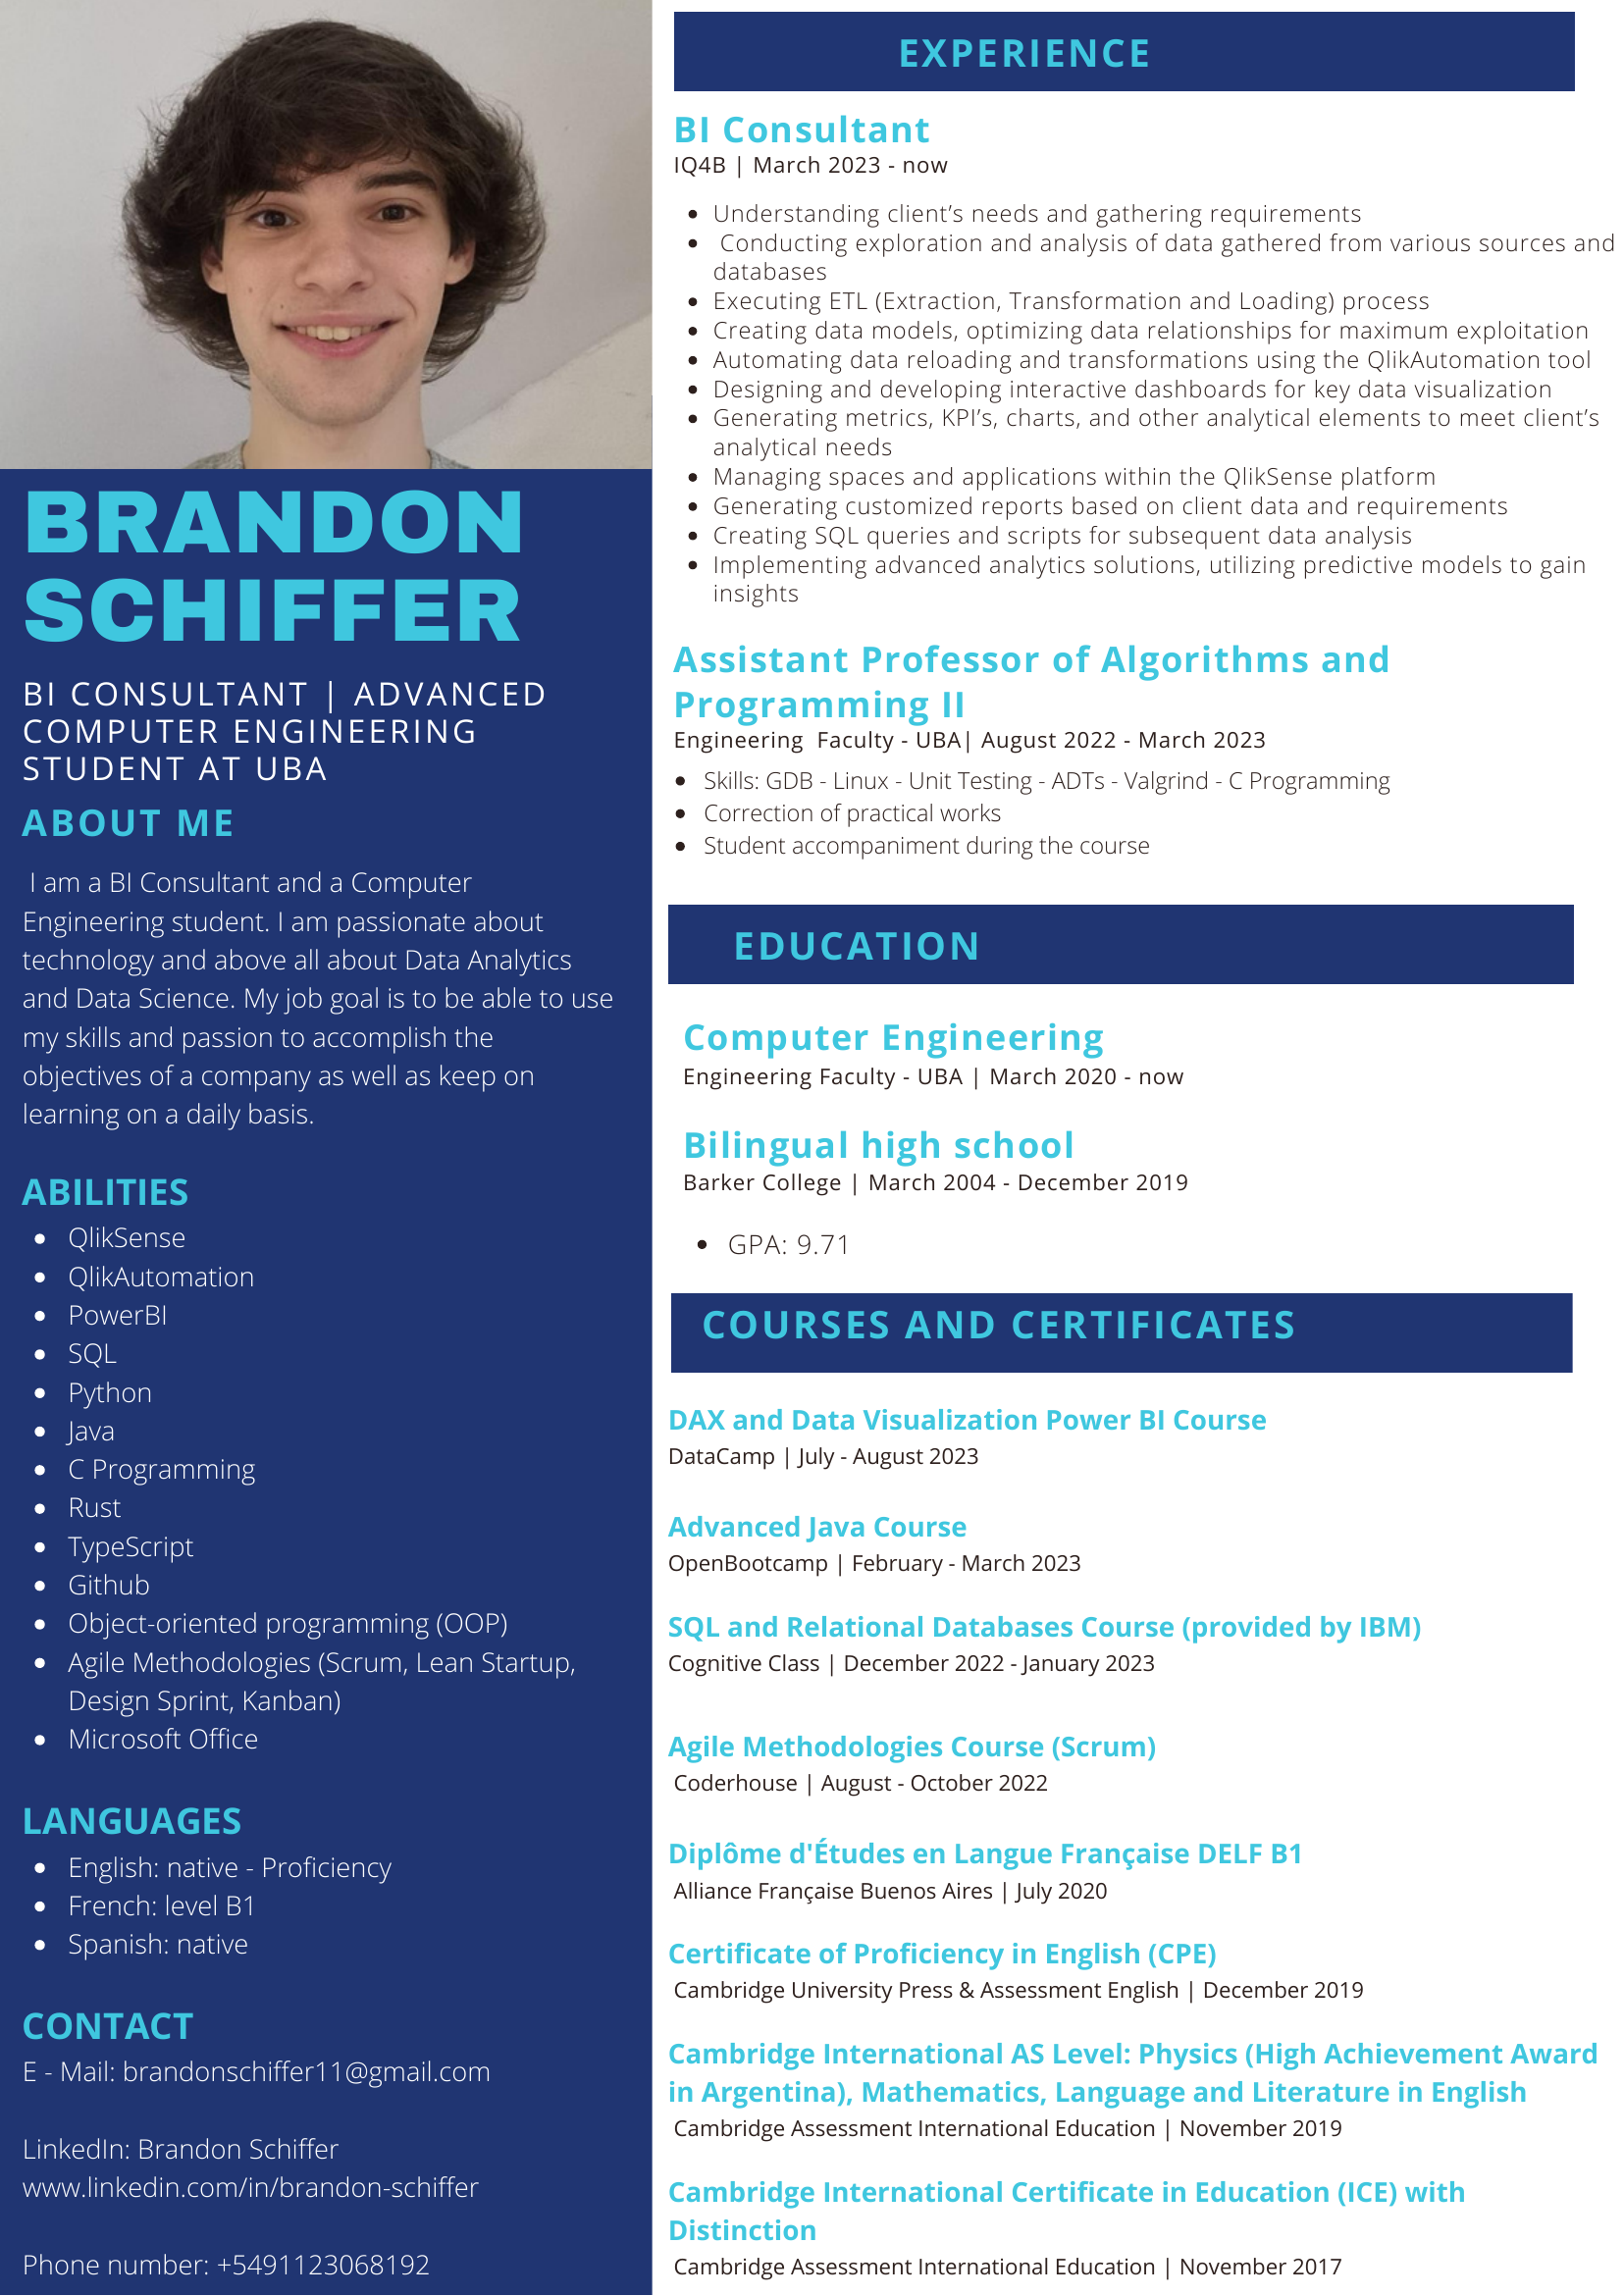

EXPERIENCE
BI Consultant
IQ4B
March 2023
now
Understanding client's needs and gathering requirements
Conducting exploration and analysis of data gathered from various sources and
databases
Executing ETL (Extraction, Transformation and Loading) process
Creating data models, optimizing data relationships for maximum exploitation
Automating data reloading and transformations using the QlikAutomation tool
Designing and developing interactive dashboards for key data visualization
Generating metrics, KPIs, charts, and other analytical elements to meet clients
analytical needs
Managing spaces and applications within the QlikSense platform
BRANDON
Generating customized reports based on client data and requirements
Creating SQL queries and scripts for subsequent data analysis
Implementing advanced analytics solutions, utilizing predictive models to gain
SCHIFFER
insights
Assistant Professor of Algorithms and
BI CONSULTANT
ADVANCED
Programming Il
COMPUTER ENGINEERING
Engineering Faculty
UBA | Au

In [ ]:
!apt-get install poppler-utils

!pip install pdf2image
!pip install easyocr

from pdf2image import convert_from_path
import easyocr
import numpy as np
import PIL
from PIL import ImageDraw
import spacy


reader = easyocr.Reader(['en'])

images = convert_from_path('/content/Resume.pdf')

from IPython.display import display, Image
display(images[0])

bounds = reader.readtext(np.array(images[0]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
bounds


def draw_boxes(image, bounds, color='yellow', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

draw_boxes(images[0], bounds)


bounds[1][1]


text=''
for i in range(len(bounds)):
  text = text + bounds[i][1] +'\n'

print(text)

nlp=spacy.load('en_core_web_sm')

doc = nlp(text)


from spacy import displacy

displacy.render(nlp(doc.text),style='ent', jupyter=True)